In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import combinations, product
import pickle
from enviroments import env_p2p, env_red

In [2]:
QL_route = 'results/Q_QL.pickle'
DQL_route = 'results/qnet_p1.pth'

model = "DQL"

In [3]:
#Fares disponibles
f = [500,400,300,200,100]
m = len(f) 

#Probabilidad de llegada de un comprador (arraibal probablity)
lambd = 0.3

# Parametro que modela la disponibilidad a pagar (Willnes to pay)
beta= 0.5

#Capacidad de la aeronave
C = 50

#Horizonte temporal máximo
T = 50

In [4]:
# Cargar el vector desde el archivo pickle
with open('results/Q_value.pickle', 'rb') as archivo:
    Q_value = pickle.load(archivo)

In [5]:
if model == "QL":
    # Cargar el vector desde el archivo pickle
    with open(QL_route, 'rb') as archivo:
        Q = pickle.load(archivo)

if model == "DQL":
    nS = 2
    nA = 32
    nH = 128

    qnet = torch.nn.Sequential(
        torch.nn.Linear(nS, nH),
        torch.nn.ReLU(),
        torch.nn.Linear(nH, nH),
        torch.nn.ReLU(),
        torch.nn.Linear(nH, nA)
    ).double()

    qnet.load_state_dict(torch.load(DQL_route))


In [6]:
def select_action(Q, s, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)
    return np.argmax(Q[s, :])

def select_action2(net, s, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)
    with torch.no_grad():
        return net(torch.tensor(np.array(s),dtype=torch.double)).argmax().item()

In [7]:
s_t = [] 
a_t = []
r_t = []

s_t2 = [] 
a_t2 = []
r_t2 = []

Rs = []
Rs2 = []

sim = 10000
max_steps = 100
env = env_p2p(lambd, beta, C, T, f, model)
env2 = env_p2p(lambd, beta, C, T, f, "QL")

nS = (C+1)*T
nA = len(env.action_space)


In [8]:
# Max time for departure
T = 50 #Max time
time = np.arange(1, T) #TIme index

#Set of products
J = 5 #Num of products
r_j = [100,200,300,400,500] #Price for products

#Set of resoruces
I = 1 #Soruce/Fly legs
c_i = np.array([50]) #Capacity for fly leg

#Customer segment
L = 1 #Types of customer
p_l = np.array([1]) #Probabilidad de pertenecer a un segmento
lambd = 0.3 #PRobabilidad de llegada de un cliente
lambd_l = lambd*p_l

#Adjacency matrix Fligt products
A_ij = np.array([
    [1, 1, 1, 1, 1]
])

with open('results/p_j.pickle', 'rb') as archivo:
    p_j = np.flip(pickle.load(archivo))
    
#Weigjt of MNL
v_lj = np.array([
    np.insert(p_j, 0, 0)
])
env = env_red(L,v_lj,r_j,c_i,T,I,A_ij,J,p_l,lambd)  

In [9]:

for episode in range(sim):
    s, _ = env.set_initial(s = [0])
    s_2, _ = env2.set_initial(s = [0,0])
    R = 0
    for step in range(max_steps):

        if model == "QL":
            a = select_action(Q, s, 0)
        if model == "DQL":
            a = select_action2(qnet, s, 0)

        s_prime, r, done, _, _ = env.step(a)
        
        r_t.append(r)
        s_t.append(s)
        a_t.append(a) 

        R += r

        if done:
            break
            
        s = s_prime
    Rs.append(R)
    R = 0
    s = s_2
    for step in range(max_steps):
        a = select_action(Q_value, s, 0)
        s_prime, r, done, _, _ = env2.step(a)
        r_t2.append(r)
        s_t2.append(s)
        a_t2.append(a) 

        R += r

        if done:
            break
            
        s = s_prime
    Rs2.append(R)


<function matplotlib.pyplot.show(close=None, block=None)>

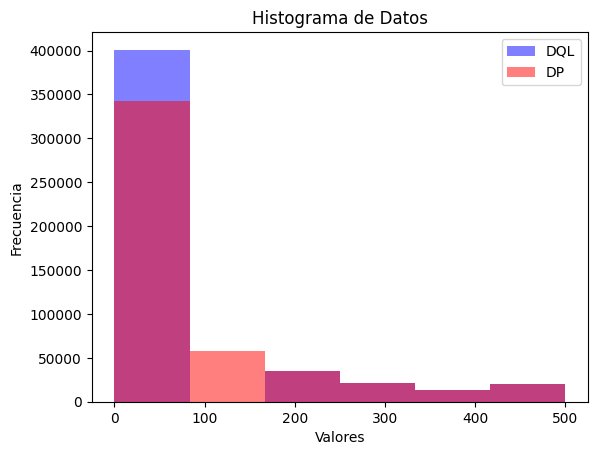

In [10]:
# Graficar el histograma
plt.hist(r_t, bins=6, alpha=0.5, color='blue',label=model)  # 'bins' determina la cantidad de divisiones en el histograma
plt.hist(r_t2, bins=6, alpha=0.5, color='red',label="DP")  # 'bins' determina la cantidad de divisiones en el histograma

plt.title('Histograma de Datos')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.legend()

plt.show

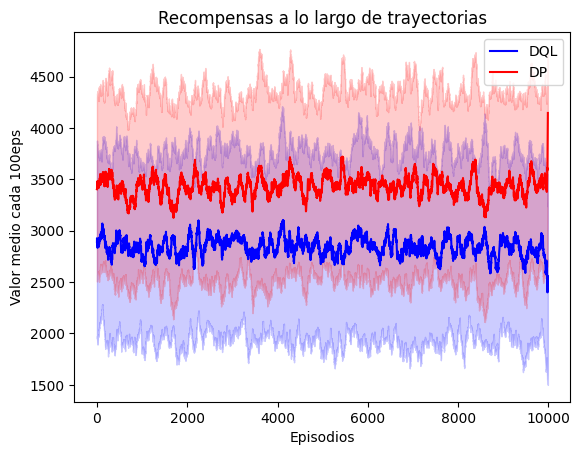

In [13]:

mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
time = np.arange(mean.size)
plt.plot(mean,color='b',label= model)
plt.fill_between(time, mean - std, mean + std, color='b', alpha=0.2)

mean = np.array([np.mean(Rs2[i:i+100]) for i in range(len(Rs2) - 10)])
std = np.array([np.std(Rs2[i:i+100]) for i in range(len(Rs2) - 10)])
time = np.arange(mean.size)
plt.plot(mean,color='r',label= "DP")
plt.fill_between(time, mean - std, mean + std, color='r', alpha=0.2)

plt.title('Recompensas a lo largo de trayectorias')
plt.xlabel('Episodios')
plt.ylabel('Valor medio cada 100eps')
plt.legend()

plt.show()

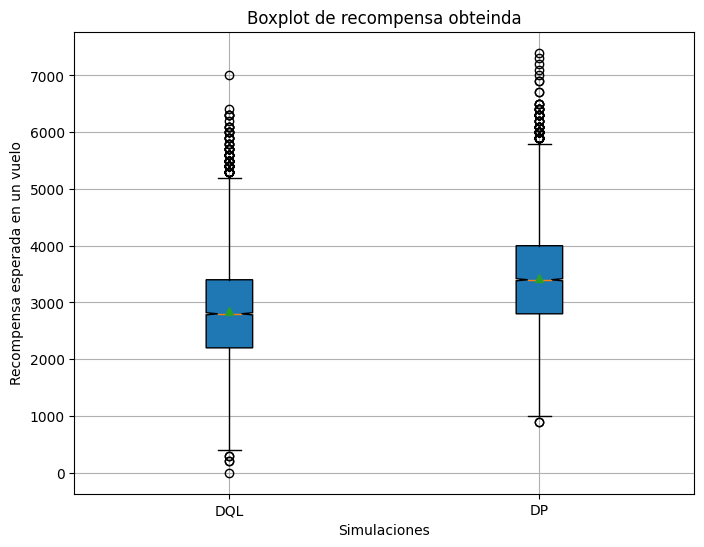

In [12]:
datos = [Rs, Rs2]
plt.figure(figsize=(8, 6))
plt.boxplot(datos, patch_artist=True, notch=True, showmeans=True)

plt.title('Boxplot de recompensa obteinda')
plt.xlabel('Simulaciones')
plt.ylabel('Recompensa esperada en un vuelo')
plt.xticks([1, 2], [model, 'DP'])  # Cambiar etiquetas del eje x
plt.grid(True)

plt.show()